Код нейросети взят с сайта https://python-scripts.com/build-neural-network , выражаю благодарность автору.
Работа выполнена в кооперации с Юрием Каныгиным, Юрием Мокропуло и Ярославом Мурзаевым.

In [84]:
import matplotlib.pyplot as plt
import random
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from IPython.display import clear_output

In [85]:
input_size = 784       # Размеры изображения = 28 x 28 = 784
hidden_size = 10      # Количество узлов на скрытом слое
num_classes = 10       # Число классов на выходе. В этом случае от 0 до 9
num_epochs = 5         # Количество тренировок всего набора данных
batch_size = 100       # Размер входных данных для одной итерации
learning_rate = 0.001  # Скорость конвергенции

In [86]:
train_dataset = dsets.MNIST(
    root='./data',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)
 
test_dataset = dsets.MNIST(
    root='./data',
    train=False,
    transform=transforms.ToTensor()
)

In [87]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
 
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [88]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()                    # Наследуемый родительским классом nn.Module
        self.fc1 = nn.Linear(input_size, hidden_size)  # 1й связанный слой: 784 (данные входа) -> 500 (скрытый узел)
        self.relu = nn.ReLU()                          # Нелинейный слой ReLU max(0,x)
        self.fc2 = nn.Linear(hidden_size, num_classes) # 2й связанный слой: 500 (скрытый узел) -> 10 (класс вывода)
    
    def forward(self, x):                              # Передний пропуск: складывание каждого слоя вместе
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [89]:
net = Net(input_size, hidden_size, num_classes)

In [90]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

Text(0,0.5,'loss')

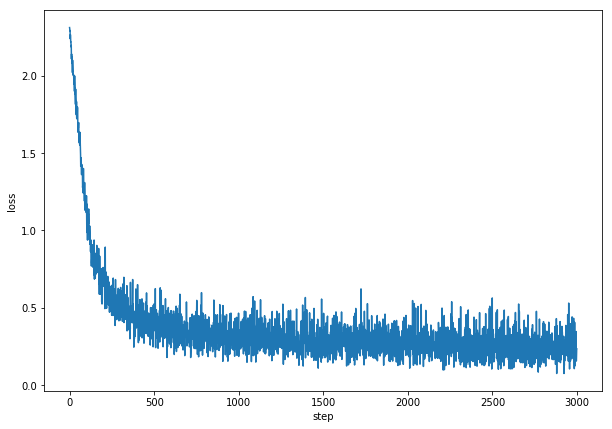

In [91]:
los = []
#step = []
#k = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):   # Загрузка партии изображений с индексом, данными, классом
        images = Variable(images.view(-1, 28*28))         # Конвертация тензора в переменную: изменяем изображение с вектора, размером 784 на матрицу 28 x 28
        labels = Variable(labels)
        
        optimizer.zero_grad()                             # Инициализация скрытых масс до нулей
        outputs = net(images)                             # Передний пропуск: определение выходного класса, данного изображения
        loss = criterion(outputs, labels)                 # Определение потерь: разница между выходным классом и предварительно заданной меткой
        loss.backward()                                   # Обратный проход: определение параметра weight
        optimizer.step()                                  # Оптимизатор: обновление параметров веса в скрытых узлах
        los.append(loss.data.numpy())
        #if (i+1) % 100 == 0:                              # Логирование
            #k = k + 1
            #print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
               #  %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))
            #step.append(k*100)
            #los.append(loss.data[0])
plt.figure(figsize=(10, 7))
plt.plot(los)
plt.xlabel("step")
plt.ylabel("loss")

In [92]:
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.view(-1, 28*28))
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)  # Выбор лучшего класса из выходных данных: класс с лучшим счетом
    total += labels.size(0)                    # Увеличиваем суммарный счет
    correct += (predicted == labels).sum()     # Увеличиваем корректный счет
 
    
print('Accuracy of the network on the 10K test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10K test images: 92 %


In [93]:
torch.save(net.state_dict(), 'fnn_model.pkl')

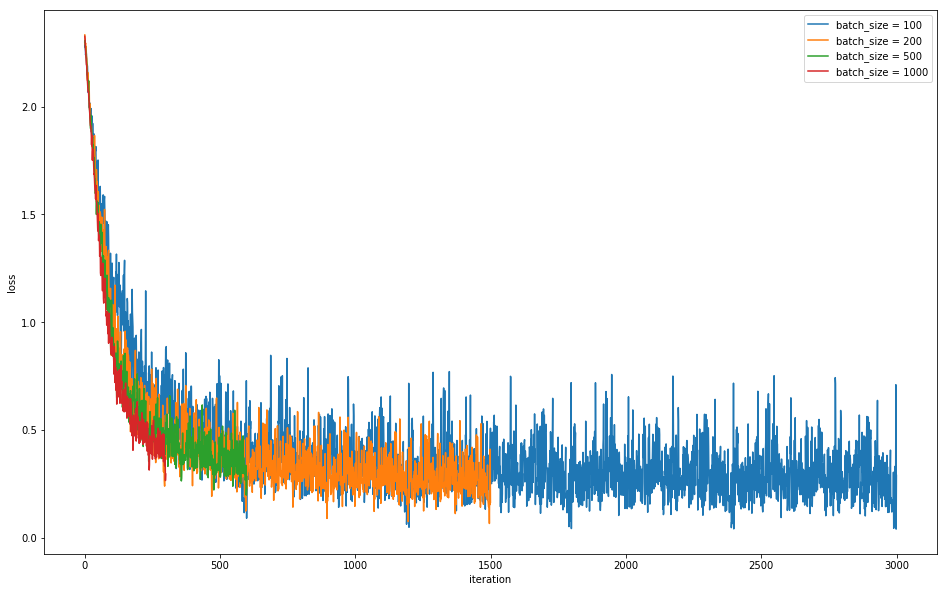

In [98]:
plt.figure(figsize=(16, 10))
plt.xlabel('iteration')
plt.ylabel('loss')
for batch_sizes in [100, 200, 500, 1000]:
    
    train_batched_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_sizes,
    shuffle=False
    )
    
    net = Net(input_size, hidden_size, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    
    history = np.array([])
    for epoch in range(num_epochs):
        for i, (images_train, labels_train) in enumerate(train_batched_loader):   # Загрузка партии изображений с индексом, данными, классом
            images_train = Variable(images_train.view(-1, 28*28))         # Конвертация тензора в переменную: изменяем изображение с вектора, размером 784 на матрицу 28 x 28
            labels_train = Variable(labels_train)

            optimizer.zero_grad()                             # Инициализация скрытых масс до нулей
            outputs = net(images_train)                             # Передний пропуск: определение выходного класса, данного изображения
            loss = criterion(outputs, labels_train)                 # Определение потерь: разница между выходным классом и предварительно заданной меткой
            loss.backward()                                   # Обратный проход: определение параметра weight
            optimizer.step()                                  # Оптимизатор: обновление параметров веса в скрытых узлах
            history = np.append(history, loss.data.numpy())
    del train_batched_loader
    plt.plot(history, label = 'batch_size = %s' % batch_sizes)
plt.legend()
plt.show()

In [101]:
dis = 5
def gauss(x, dis):
    noize_normal = np.random.normal(0, dis, size = np.array(x).shape)  #Эта функция пригодится ниже для зашумления даннных
    np_to_image = np.array(x) + np.abs(noize_normal)
    np_expand_dims = np.expand_dims(np_to_image, axis=2)
    return np.uint8(np_expand_dims)

In [102]:
train_dataset_noisy = dsets.MNIST(
    root='./data',
    train=True,
    transform=transforms.Compose(
        [
            transforms.Lambda(lambda x: gauss(x, dis)) , #Добавляем шумы в исходные данные
            transforms.ToPILImage() ,
            transforms.ToTensor()
        ]),
    download=True
)
 
test_dataset = dsets.MNIST(
    root='./data',
    train=False,
    transform=transforms.ToTensor()
)

In [103]:
train_loader_noisy = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
 
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

## Исходная картинка из базы:

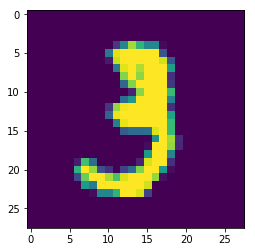

In [104]:
plt.imshow(train_dataset.__getitem__(10)[0].reshape((28,28))) 

## Та же картинка, но зашумленная:

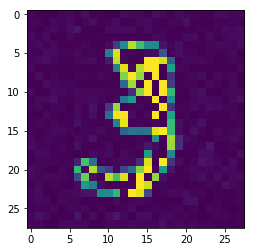

In [105]:
plt.imshow(train_dataset_noisy.__getitem__(10)[0].reshape((28,28)))

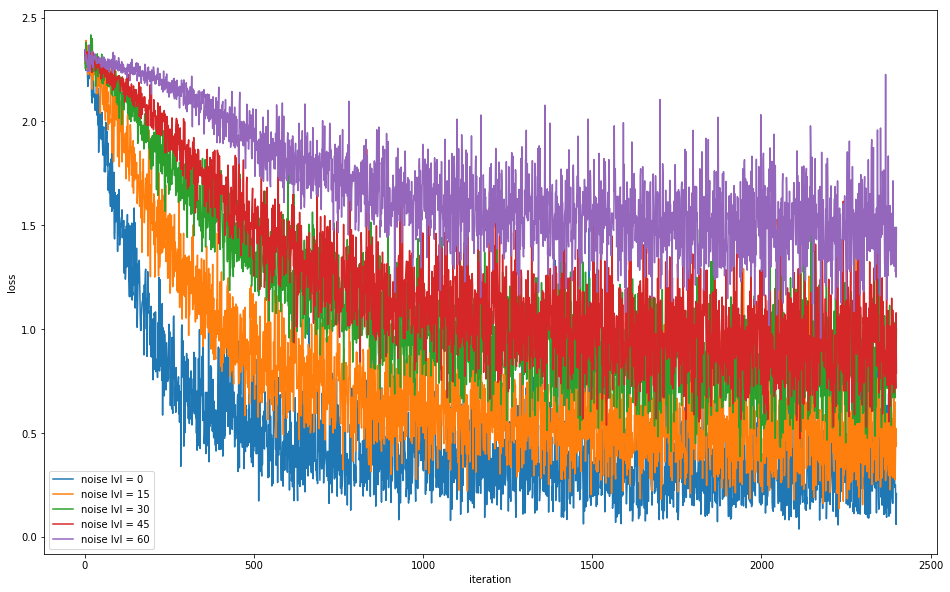

In [79]:
plt.figure(figsize=(16, 10))
plt.xlabel('iteration')
plt.ylabel('loss')
for dis in np.arange(0, 75, 15):
    
    train_dataset_noisy = dsets.MNIST(
    root='./data',
    train=True,
    transform=transforms.Compose(
        [
            transforms.Lambda(lambda x: gauss(x, dis)) ,
            transforms.ToPILImage() ,
            transforms.ToTensor()
        ]),
    download=True
    )
    
    train_loader_noisy = torch.utils.data.DataLoader(
    dataset=train_dataset_noisy,
    batch_size=batch_size,
    shuffle=True
    )
    
    net = Net(input_size, hidden_size, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    
    history = []
    for i, (images_train, labels_train) in enumerate(train_loader_noisy):   # Загрузка партии изображений с индексом, данными, классом
        images_train = Variable(images_train.view(-1, 28*28))         # Конвертация тензора в переменную: изменяем изображение с вектора, размером 784 на матрицу 28 x 28
        labels_train = Variable(labels_train)

        optimizer.zero_grad()                             # Инициализация скрытых масс до нулей
        outputs = net(images_train)                             # Передний пропуск: определение выходного класса, данного изображения
        loss = criterion(outputs, labels_train)                 # Определение потерь: разница между выходным классом и предварительно заданной меткой
        loss.backward()                                   # Обратный проход: определение параметра weight
        optimizer.step()                                  # Оптимизатор: обновление параметров веса в скрытых узлах
        history.append(loss.data.numpy())

    plt.plot(history, label = 'noise lvl = %s' % dis)
plt.legend()
plt.show()